In [ ]:
# Zachary Katz
# zachary_katz@mines.edu
# November 2024

"""
Plot Figure 3,4,S3,S4 for Whillans Catalog Paper
Figure 3: Events on top of tides
Figure 4: 45-Day Rolling Mean
Figure S3: Events at different tides
Figure S4: 3-Day Rolling Mean
Figure S5: 27-Day Rolling Mean


v1.0: 01 November 2024
    Plots for Whillans Catalog Paper

"""

# Imports
import datetime
import sys

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker


import pandas as pd
import numpy as np
import scipy

from pyproj import CRS, Transformer
import shapefile
import shapely
from shapely.plotting import plot_line
from shapely.geometry import LineString

from cmap import Colormap
import xarray as xr
import rasterio


sys.path.insert(
    0,
    "/mnt/c/Users/ZacharyKatz/Desktop/WhillansCatPaper/WhillansCatalogPaper/src/Tides",
)
import Tides

%reload_ext autoreload
%autoreload


################################################################################
########################## User Defined Variables ##############################

min_stas = 2  # Which catalog to use
tide_dir = "/mnt/c/Users/ZacharyKatz/Desktop/Research/Background"
tide_mod = "CATS2008-v2023"

########################## User Defined Variables ##############################
################################################################################

In [3]:
# Load slip times based on second derivative
ev_data = {"event": [], "trace_time": []}
df = pd.read_csv(f"../AllEventStartTimes_{min_stas}stas.txt", sep="\t")
ev_data["ev_time"] = df["EventStartTime"]

# Load no data from txt file
no_data = {"interval": [], "starts": [], "ends": []}
df = pd.read_csv(f"../no_data_{min_stas}stas.txt", sep="\t")
no_data["starts"] = df["start"]
no_data["ends"] = df["end"]
diff = [
    datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
    - datetime.datetime.strptime(y, "%Y-%m-%d %H:%M:%S")
    for x, y in zip(no_data["ends"], no_data["starts"])
]
no_data["interval"] = diff

In [4]:
# Calculate time since last events
time_since_last_ev = [
    datetime.timedelta(seconds=1000000)
]  # Set large for first event because prior event time unknown
for i, event in enumerate(ev_data["ev_time"]):
    if i > 0:
        current = datetime.datetime.strptime(event, "%Y-%m-%d %H:%M:%S")
        prior = datetime.datetime.strptime(
            ev_data["ev_time"][i - 1], "%Y-%m-%d %H:%M:%S"
        )
        diff = current - prior
        # Check if data gap in current - prior and remove event from consideration
        for j, gap in enumerate(no_data["interval"]):
            if (
                prior
                < datetime.datetime.strptime(no_data["ends"][j], "%Y-%m-%d %H:%M:%S")
                < current
            ):
                diff = datetime.timedelta(seconds=1000000)
        time_since_last_ev.append(diff)
ev_data["time_since_last_ev"] = time_since_last_ev
print([(a.days * 24 * 3600 + a.seconds) / 3600 for a in ev_data["time_since_last_ev"]])

[277.77777777777777, 17.354166666666668, 21.766666666666666, 10.758333333333333, 13.254166666666666, 19.1125, 22.970833333333335, 10.4875, 11.895833333333334, 9.975, 14.345833333333333, 9.975, 14.845833333333333, 9.9875, 14.658333333333333, 12.0625, 13.1375, 9.808333333333334, 15.225, 10.9875, 14.591666666666667, 10.625, 15.1, 23.866666666666667, 8.416666666666666, 16.3375, 21.929166666666667, 10.666666666666666, 14.5875, 18.954166666666666, 14.941666666666666, 10.7375, 20.645833333333332, 13.025, 12.041666666666666, 11.0125, 13.125, 9.525, 15.145833333333334, 8.875, 15.625, 8.2875, 16.266666666666666, 8.525, 16.9125, 8.5125, 16.4875, 8.55, 19.804166666666667, 16.733333333333334, 11.6625, 12.2, 12.983333333333333, 13.9, 21.4, 20.2, 12.008333333333333, 11.979166666666666, 11.516666666666667, 12.891666666666667, 11.183333333333334, 13.1125, 11.1, 13.5125, 11.545833333333333, 13.420833333333333, 10.85, 14.083333333333334, 10.420833333333333, 14.325, 11.045833333333333, 16.941666666666666,

[(-174.11568595746584, -84.38504722396503), (-174.07363790894706, -84.38708087490528), (-174.03252834334145, -84.38929637003153), (-173.9941263318061, -84.39193572017322), (-173.95194821792526, -84.39181611372216), (-173.90710899077706, -84.39045168887456), (-173.86118811502547, -84.38949590176401), (-173.8148291962652, -84.38878233553352), (-173.76803047357416, -84.38841239171828), (-173.72112609045024, -84.38834365932638), (-173.6742274584149, -84.38855870689241), (-173.62764576571297, -84.38910967700275), (-173.5814536310214, -84.38993610577346), (-173.53591166420026, -84.3910466307691), (-173.49112552234823, -84.39243260584267), (-173.44773757602218, -84.39419044387766), (-173.40529722592322, -84.39616056496061), (-173.36429498918946, -84.39840763385244), (-173.32440343132876, -84.40084127031444), (-173.28402159579116, -84.40319834133297), (-173.24328319333878, -84.40550028801066), (-173.20251122152564, -84.4077994127134), (-173.16170568018524, -84.41009571193077), (-173.1203332639

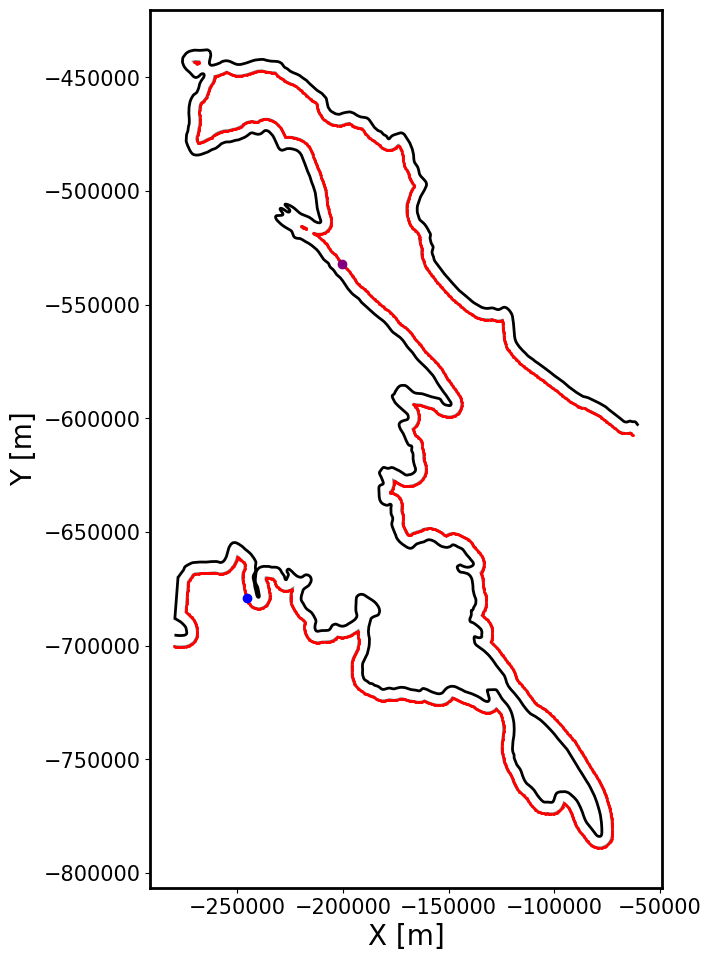

In [5]:
# Calculate difference in tides across basin at event times (from icesat2/gztides.ipynb)
# Helper functions
def inBox(points, bbox):
    # Return points from points that are in bbox
    inbox = []
    for point in points:
        x = point[0]
        y = point[1]
        if x > bbox[0] and x < bbox[2] and y > bbox[1] and y < bbox[3]:
            inbox.append(point)
    return inbox


def interpolateLine(line, dist):
    # Return a new list of points from a linestring that has been interpolated at
    # distance dist. Line must be linestring, dist in m for our case

    # Follows example from:
    # https://stackoverflow.com/questions/34906124/interpolating-every-x-distance-along-multiline-in-shapely
    length = shapely.length(line)
    num_vert = int(np.round(length / dist))
    # print(num_vert)
    return [line.interpolate(n * dist) for n in range(num_vert)]


def xy2ll(x, y):
    """
     Transform coordinates to geodetic coordinates (lon, lat)
     from Antarctic Polar Stereograph coordinates (x, y)

    lon,lat = xy2ll(x,y)
    """
    crs_ll = CRS("EPSG:4326")
    crs_xy = CRS("EPSG:3031")
    xy_to_ll = Transformer.from_crs(crs_xy, crs_ll, always_xy=True)
    lon, lat = xy_to_ll.transform(x, y)
    return lon, lat


def ll2xy(lon, lat):
    """
    Transform coordinates from input geodetic coordinates (lon, lat)
    to output Antarctic Polar Stereographic coordinates (x, y)
    Can also take lists of floats!

    Parameters
    lon - Geodetic longitude in EPSG:4326 [float]
    lat - Geodetic latitude in EPSG:4326 [float]

    Returns
    x - Antarctic Polar Stereographic (EPSG:3031) x [float]
    y - Antarctic Polar Stereographic (EPSG:3031) y [float]
    """

    crs_ll = CRS("EPSG:4326")
    crs_xy = CRS("EPSG:3031")
    ll_to_xy = Transformer.from_crs(crs_ll, crs_xy, always_xy=True)
    x, y = ll_to_xy.transform(lon, lat)
    return x, y


def dist_sq(x, y):
    # Returns min dist squared between two points
    delta_x = y[0] - x[0]
    delta_y = y[1] - x[1]
    return delta_x * delta_x + delta_y * delta_y


# Extract coordinates of grounding line

# Tuning parameters
offset = 5000  # Distance from grounding line to offset, m
pt_dist = 500  # Distance between tide sampling points, m

# Arrays to pass to tides
x_tide = []
y_tide = []

bbox = [-280000, -800000, -60000, -420000]  # Includes all of Crary
fig, ax = plt.subplots(
    figsize=[(bbox[2] - bbox[0]) / 100000 * 3, (bbox[3] - bbox[1]) / 100000 * 3]
)
# gl_path = '/mnt/d/Background/Antarctica_masks/scripps_antarctica_polygons_v1.shp'
gl_path = "/mnt/c/Users/ZacharyKatz/Desktop/Research/Background/Antarctica_masksX/scripps_antarctica_polygons_v1.shp"
sf = shapefile.Reader(gl_path)
for i, shape in enumerate(sf.shapes(bbox=bbox)):
    if i == 3:
        points = shape.points
        # Only get points within bounding box
        inbox = inBox(points, bbox)
        line = LineString(inbox)
        dilated = line.buffer(3000, single_sided=True)
        offset_line = line.offset_curve(offset)
        plot_line(line, ax=ax, add_points=False, color="black")
        plot_line(offset_line, ax=ax, add_points=False, color="gray")
        # plot_polygon(dilated, ax=ax, add_points=False, color='black')

        interpolated = interpolateLine(offset_line, pt_dist)
        xs = [point.x for point in interpolated]
        ys = [point.y for point in interpolated]
        ax.scatter(xs, ys, s=1, color="red")
        x_tide.append(xs)
        y_tide.append(ys)

ax.xaxis.set_major_locator(ticker.MultipleLocator(50000))
ax.yaxis.set_major_locator(ticker.MultipleLocator(50000))
ax.set_xlabel("X [m]", size=20)
ax.set_ylabel("Y [m]", size=20)
ax.tick_params(labelsize=15)

# Flatten the list. Not sure why this works but here's the source
# https://www.scaler.com/topics/flatten-list-python/
x_tide = sum(x_tide, [])
y_tide = sum(y_tide, [])

lon_lats = [xy2ll(x0, y0) for x0, y0 in zip(x_tide, y_tide)]
lons = [x[0] for x in lon_lats]
lats = [x[1] for x in lon_lats]
print(lon_lats)

x_south = lon_lats[900][0]
y_south = lon_lats[900][1]
x_north = lon_lats[-200][0]
y_north = lon_lats[-200][1]
x_n, y_n = ll2xy(x_north, y_north)
x_s, y_s = ll2xy(x_south, y_south)
ax.scatter(x_n, y_n, color="blue", zorder=2)
ax.scatter(x_s, y_s, color="purple", zorder=2)

[-62593.440298971465, -63016.262162440245, -63426.72885198084, -63803.32861822993, -64251.12006032353, -64741.448041472104, -65238.66050305062, -65737.79263011392, -66237.60086600333, -66734.9613396404, -67228.82329973437, -67715.18756836123, -68193.93486542544, -68662.13336939174, -69118.70502341053, -69555.60020087584, -69979.50116592874, -70384.3764211318, -70774.78343900069, -71170.9365012661, -71571.16062239397, -71971.38474352178, -72371.60886464946, -72778.65610430592, -73185.85611203789, -73593.05611976978, -74000.25612750137, -74407.45613523344, -74814.65614296516, -75221.85615069704, -75629.0561584288, -76036.25616616069, -76443.45617389253, -76843.3949710638, -77235.73406987752, -77621.3035245648, -78006.87297925178, -78404.33373114694, -78844.54962243764, -79284.76551372795, -79724.98140501887, -80165.19729630939, -80605.41318759977, -81054.42103435477, -81508.4711856762, -81962.52133699808, -82416.57148831968, -82870.62163964126, -83324.67179096291, -83778.72194228432, -84

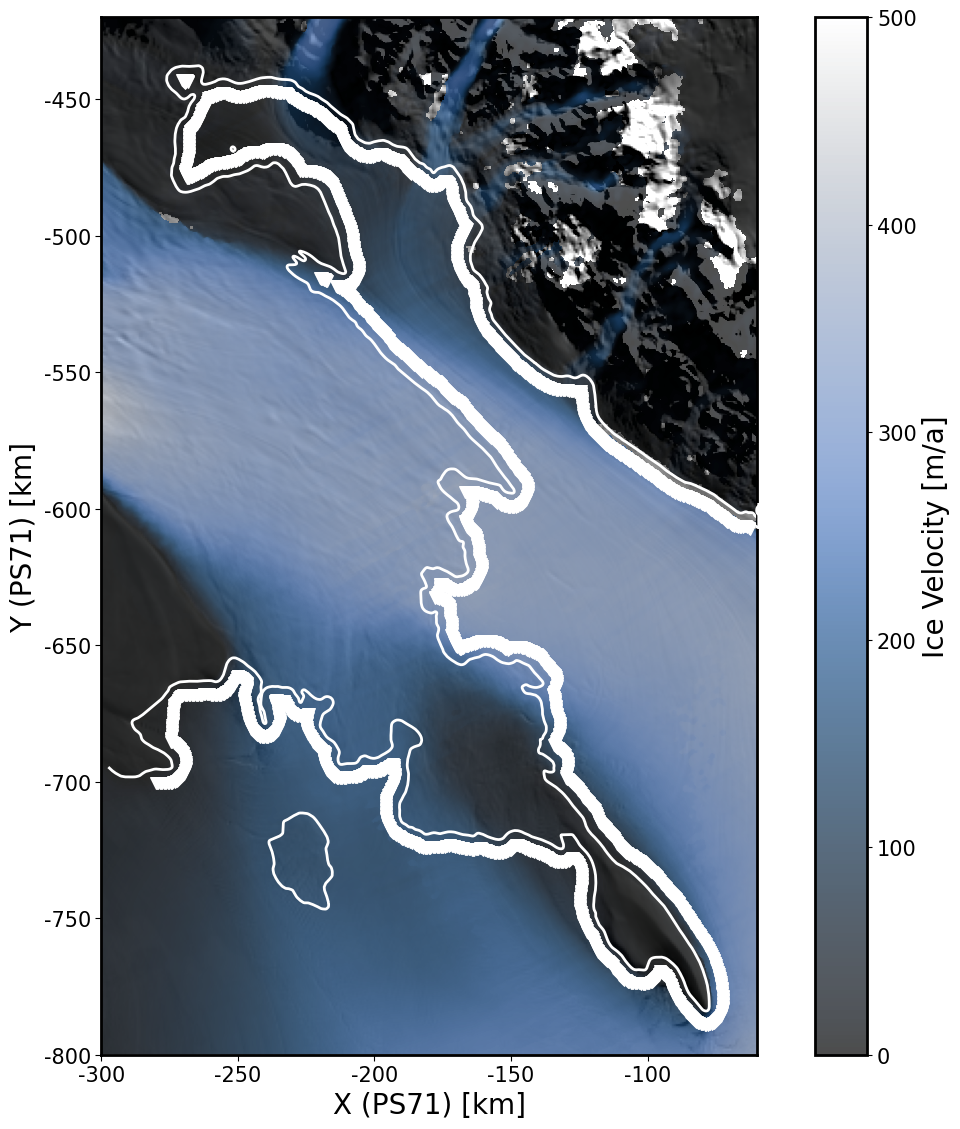

In [6]:
# Plot tide locations

vel_mag_path = "/mnt/c/Users/ZacharyKatz/Desktop/Research/Background/antarctic_ice_vel_phase_map_v01-vmag.nc"
moa_path = (
    "/mnt/c/Users/ZacharyKatz/Desktop/Research/Background/moa750_2009_hp1_v1.1.tif"
)
vel_mag = xr.open_dataarray(vel_mag_path)
bbox = [-300000, -800000, -60000, -420000]  # Includes all of Crary
vel_mag = vel_mag.isel(x=slice(4000, 8000), y=slice(6000, 8000))
x_min_v, x_max_v = vel_mag["x"].min().item(), vel_mag["x"].max().item()
y_min_v, y_max_v = vel_mag["y"].min().item(), vel_mag["y"].max().item()

with rasterio.open(moa_path) as moa:
    bounds = moa.bounds
    left, bottom, right, top = bounds.left, bounds.bottom, bounds.right, bounds.top
    moa_dat = moa.read(1)

ext = (left, right, bottom, top)


oslo = Colormap("crameri:oslo").to_mpl()
# Static frame
bbox = [-300000, -800000, -60000, -420000]  # Includes all of Crary
gl_path = "/mnt/c/Users/ZacharyKatz/Desktop/Research/Background/Antarctica_masksX/scripps_antarctica_polygons_v1.shp"
sf = shapefile.Reader(gl_path)
fig, ax = plt.subplots(
    figsize=[(bbox[2] - bbox[0]) / 100000 * 5, (bbox[3] - bbox[1]) / 100000 * 3]
)
fig.set_tight_layout(True)
ax.imshow(moa_dat, extent=ext, cmap="gray", vmin=15000, vmax=17000)
v = ax.imshow(
    vel_mag,
    extent=(x_min_v, x_max_v, y_min_v, y_max_v),
    cmap=oslo,
    vmax=500,
    vmin=0,
    alpha=0.7,
)
for i, shape in enumerate(sf.shapes(bbox=bbox)):
    if i > 0:
        points = shape.points
        # Only get points within bounding box
        inbox = inBox(points, bbox)
        line = LineString(inbox)
        plot_line(line, ax=ax, add_points=False, color="white")
x_min, x_max = bbox[0], bbox[2]
y_min, y_max = bbox[1], bbox[3]
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
KM_SCALE = 1e3
ticks_x = ticker.FuncFormatter(lambda x, pos: "{0:g}".format(x / KM_SCALE))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = ticker.FuncFormatter(lambda x, pos: "{0:g}".format(x / KM_SCALE))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_xlabel("X (PS71) [km]", size=20)
ax.set_ylabel("Y (PS71) [km]", size=20)
ax.tick_params(labelsize=15)
ax.tick_params(size=4)
# ax.set_facecolor("black")
cbarv = fig.colorbar(v)
cbarv.ax.tick_params(labelsize=15)
cbarv.ax.set_ylabel("Ice Velocity [m/a]", size=20)
x, y = ll2xy(lons, lats)
places = ["gz05", "North", "South"]
ax.scatter(x, y, s=70, color="white", marker="v")
print(x)
ax.text(x[0] + 2000, y[0], "gz05", color="white", size=25)
ax.text(x[1] + 2000, y[1], "North", color="white", size=25)
ax.text(x[2] + 2000, y[2], "South", color="white", size=25)

fig.tight_layout()

In [7]:
# Tide time series at gz05
%autoreload

spacing = 4  # Minutes
dates_timeseries = []
initial_time = datetime.datetime.strptime("2007-12-01 00:00:00", "%Y-%m-%d %H:%M:%S")
for i in range(24 * 365 * 12 * 15):  # 15 tides/min * 24 hours * 365 *11 years
    dates_timeseries.append(initial_time + datetime.timedelta(minutes=spacing * i))

lats = [-84.2986, y_north, y_south]
lons = [-164.5206, x_north, x_south]
places = ["gz05", "North", "South"]

lats = [-84.2986]
lons = [-164.5206]
places = ["gz05"]

tides = Tides.Tide(tide_mod, tide_dir)
for lat, lon, place in zip(lats, lons, places):
    ev_data[f"tides{place}"] = tides.tidal_elevation(
        [lon],
        [lat],
        dates_timeseries,
    ).data.T[0]

['m2', 's2', 'n2', 'k2', 'k1', 'o1', 'p1', 'q1', 'mf', 'mm']


In [25]:
# Hilbert
analytic_signal = scipy.signal.hilbert(ev_data["tidesgz05"])
amplitude_envelope = np.abs(analytic_signal)

# Savitzky-Golay
envelope = scipy.signal.savgol_filter(ev_data["tidesgz05"], 2000, 3)


# Rolling average of min/max over 14 days
# 4 min/obs * 1000 obs = 4000 min = 2.8 days
rolling_max = pd.Series(ev_data["tidesgz05"]).rolling(window=400, center=True).max()

to_plot = amplitude_envelope

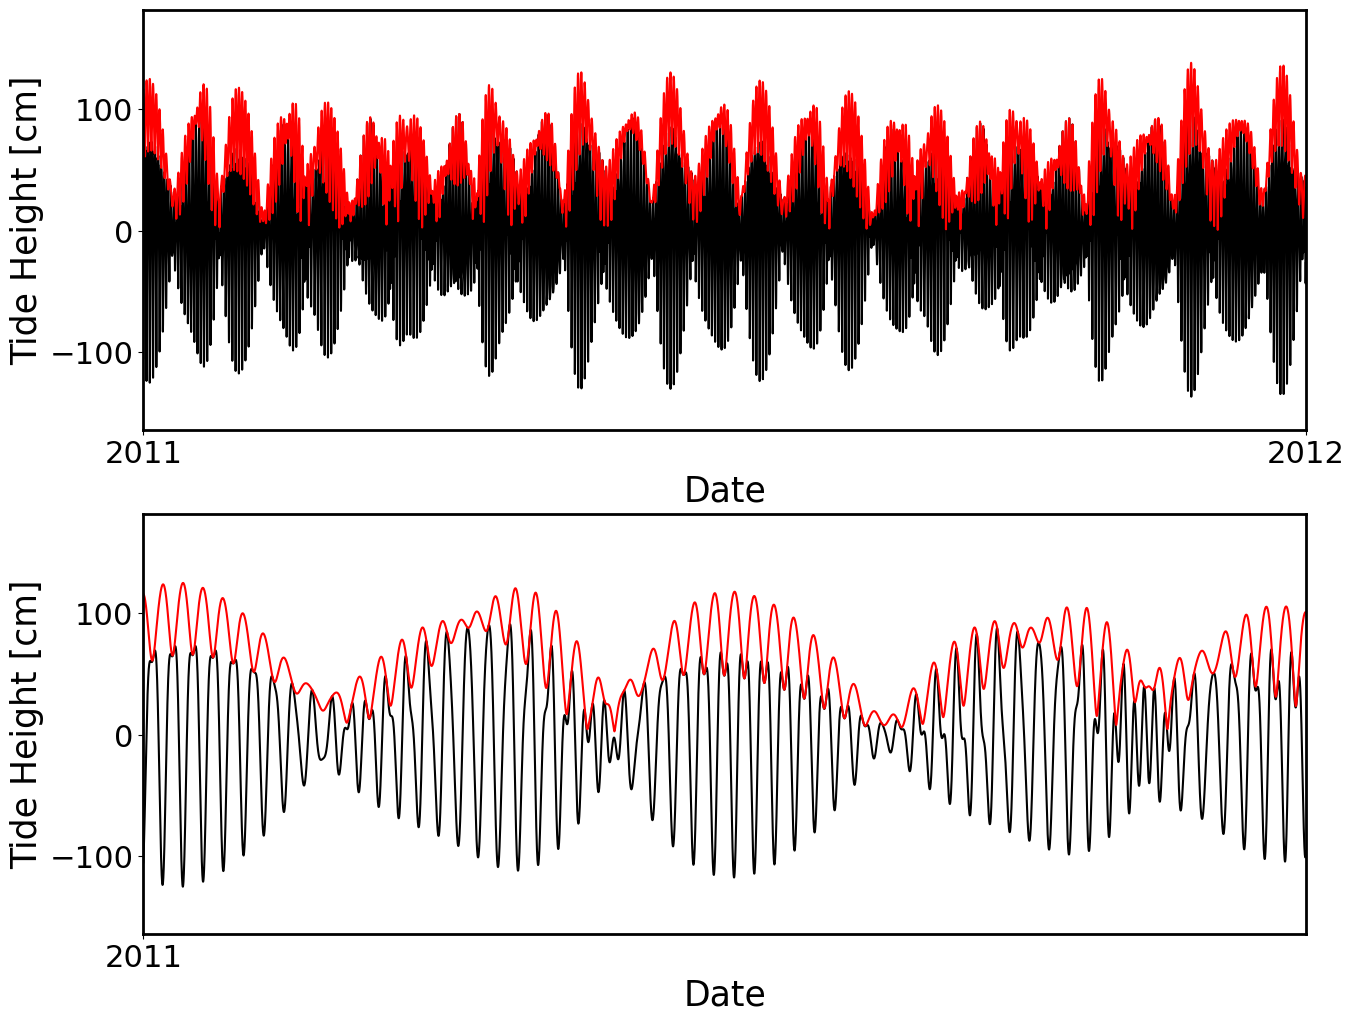

In [26]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=[15, 12])


def panel(ax, st, ed):
    ax.plot(dates_timeseries, ev_data["tidesgz05"], label="gz05", color="black")
    ax.plot(dates_timeseries, to_plot, label="gz05 envelope", color="red")
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.set_ylabel("Tide Height [cm]", size=25)
    ax.set_xlabel("Date", size=25)
    ax.xaxis.set_tick_params(labelsize=22)
    ax.yaxis.set_tick_params(labelsize=22)
    ax.set_xlim(st, ed)


panel(ax1, datetime.datetime(2011, 1, 1), datetime.datetime(2012, 1, 1))
panel(ax2, datetime.datetime(2011, 1, 1), datetime.datetime(2011, 3, 1))

In [51]:
# Envelope scipy
# Convert datetimes to decimal days
dates_timeseries = np.array(dates_timeseries)
time_seconds = dates_timeseries - dates_timeseries[0]
# Convert time seconds into total seconds
time_seconds = np.array([a.days * 24 * 3600 + a.seconds for a in time_seconds])
# Convert time seconds into total days
time_days = time_seconds / 86400

# Calculate envelope from scipy example https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.envelope.html
n, n_out = (
    len(time_days),
    len(time_days),
)  # number of signal samples and envelope samples
T = time_days[-1] / n  # sampling interval
print(T)
t = np.arange(n) * T  # time stamps
x = ev_data["tidesgz05"]  # the signal
bp_in = (None, int(1 / (12 / 15) * (n * T)))  # Lo
x_env, x_res = scipy.signal.envelope(x, bp_in, n_out=n_out)
t_out = np.arange(n_out) * (n / n_out) * T

0.0027777760161226675


In [72]:
def panel(ax, st, ed, ts, env, color, lab):
    ax.plot(dates_timeseries, ts, color="black")
    ax.plot(dates_timeseries, env, label=lab, color=color)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.set_ylabel("Tide Height [cm]", size=25)
    ax.xaxis.set_tick_params(labelsize=22)
    ax.yaxis.set_tick_params(labelsize=22)
    ax.set_xlim(st, ed)
    ax.legend(fontsize=20)

/tmp/ipykernel_109055/933805380.py:23: RuntimeWarning: divide by zero encountered in divide
  period = 1 / tf / SEC_TO_HR / HR_TO_DAY  # Day


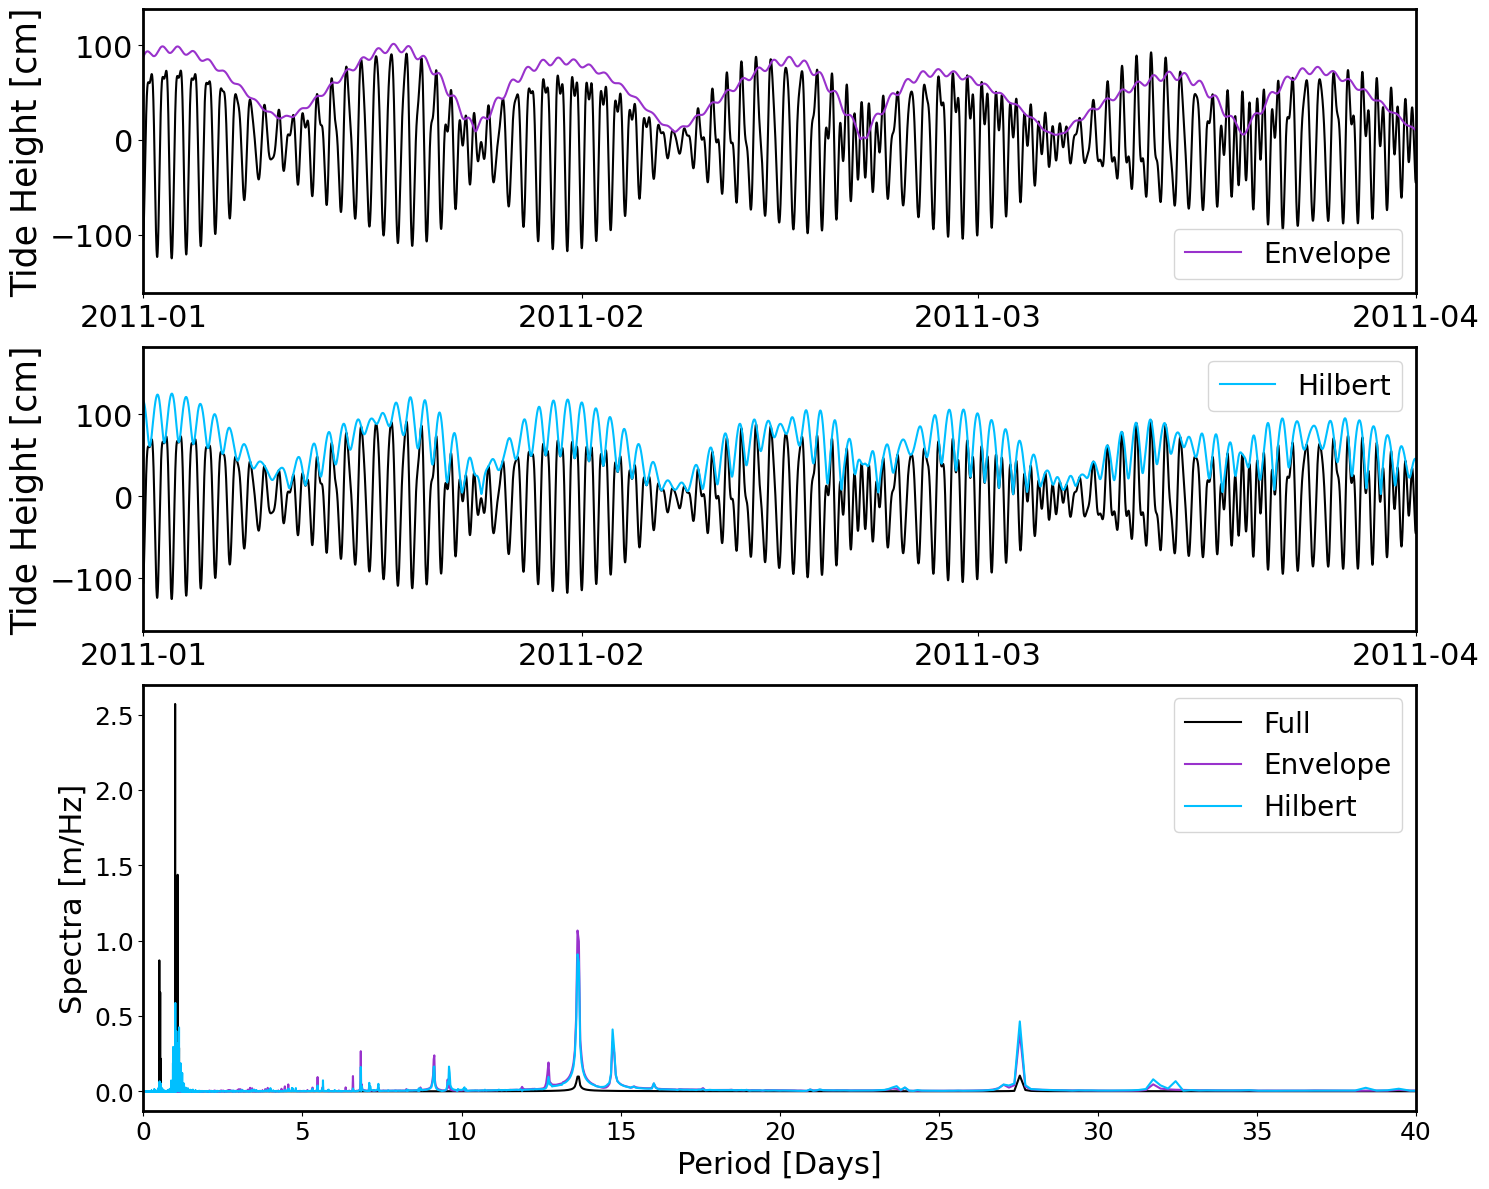

In [77]:
# Spectra of amplitude_envelope and x_env
SEC_TO_HR = 3600
HR_TO_DAY = 24
fig, (ax1, ax2, ax3) = plt.subplots(
    3, 1, figsize=[15, 12], gridspec_kw={"height_ratios": [1, 1, 1.5]}
)

panel(
    ax1,
    datetime.datetime(2011, 1, 1),
    datetime.datetime(2011, 4, 1),
    x,
    x_env,
    "darkorchid",
    "Envelope",
)
panel(
    ax2,
    datetime.datetime(2011, 1, 1),
    datetime.datetime(2011, 4, 1),
    x,
    amplitude_envelope,
    "deepskyblue",
    "Hilbert",
)


# Make Spectrum
labels = ["Full", "Envelope", "Hilbert"]
colors = ["black", "darkorchid", "deepskyblue"]
for i, data in enumerate([ev_data["tidesgz05"], x_env, amplitude_envelope]):
    N = len(dates_timeseries)
    T = 4 * 60  # Time between samples
    t = np.linspace(0.0, N * T, N, endpoint=False)
    detrended_x = scipy.signal.detrend(data) / 100
    hann = scipy.signal.windows.hann(N)
    hanned_x = detrended_x * hann  # Hann filter before Fourier Transform

    xf = scipy.fft.fft(detrended_x)
    tf = scipy.fft.fftfreq(N, T)[: N // 2]
    period = 1 / tf / SEC_TO_HR / HR_TO_DAY  # Day
    ax3.plot(
        period, 12.0 / N * np.abs(xf[0 : N // 2]), label=labels[i], color=colors[i]
    )

ax3.set_xlim(0, 40)
ax3.set_xlabel("Period [Days]", fontsize=22)
ax3.set_ylabel("Spectra [m/Hz]", fontsize=22)
ax3.xaxis.set_tick_params(labelsize=18)
ax3.yaxis.set_tick_params(labelsize=18)
ax3.legend(fontsize=20)
fig.tight_layout()